In [1]:
import time
from tqdm import tqdm
from utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

sns.set_theme(style="white")

from sklearn import manifold, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from keras.applications.vgg16 import VGG16
from keras import Model
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# from PIL import Image
# Image.MAX_IMAGE_PIXELS = int(1e9) # increase maximum size of loaded images

import cv2

# Image processing using SIFT

In [4]:
def imshow(image, cmap="gray"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

## Preparing data

### Creating the dataset

In [2]:
# import data
df = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
df_text = pd.read_csv("data/df_text.csv", index_col=0)

categories = list(df_text["category"].unique())  # liste des catégories
n_labels = len(categories)  # nombre de catégories

# encoding categories
cat_labels = df_text["category"].apply(lambda x: categories.index(x)).values

# create Dataframe
df_images = pd.DataFrame(
    {
        "image_path": df["image"].map(lambda x: f"./data/images/{x}"),
        "category": df_text["category"],
        "label": cat_labels,
    }
)
df_images.to_csv("data/df_images.csv")
df_images.head()

,image_path,category,label
0,./data/images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,0
1,./data/images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,1
2,./data/images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,1
3,./data/images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,0
4,./data/images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,0


### Display example images

                           Home Furnishing                            


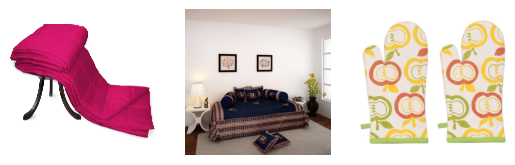

                              Baby Care                               


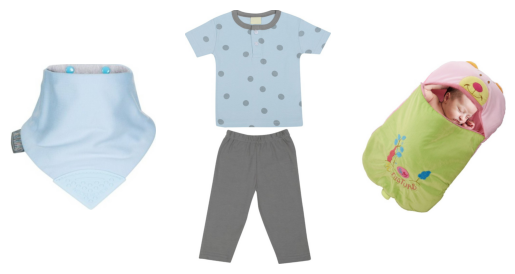

                               Watches                                


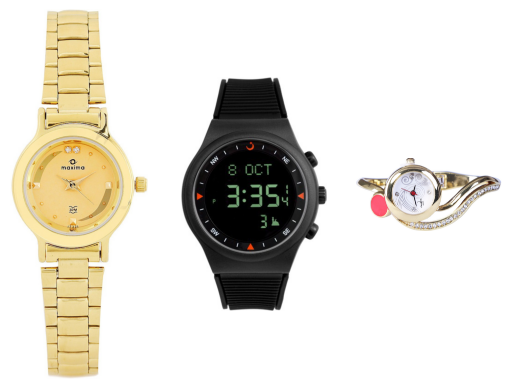

                      Home Decor & Festive Needs                      


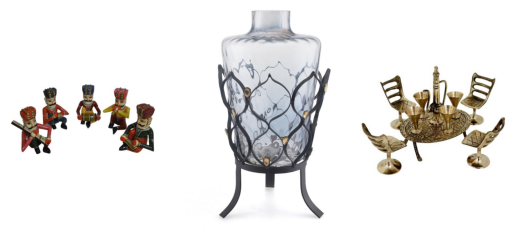

                           Kitchen & Dining                           


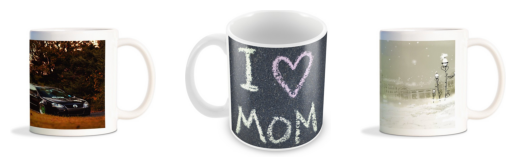

                       Beauty and Personal Care                       


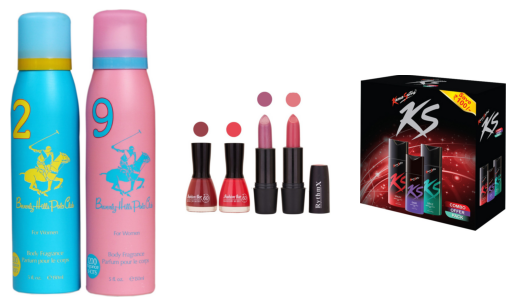

                              Computers                               


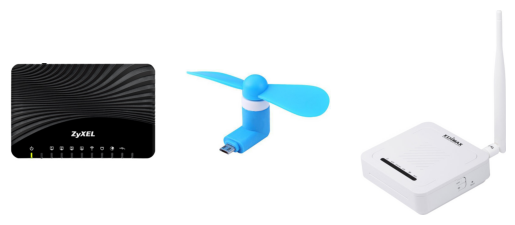

In [5]:
# display 3 images per category
for cat in categories:
    print(cat.center(70))
    paths = list(
        df_images.loc[df_images["category"] == cat, "image_path"].sample(
            3, random_state=3
        )
    )
    for i in range(3):
        plt.subplot(130 + 1 + i)
        image = imread(paths[i])
        imshow(image)
    plt.show()

## Detection of SIFT descriptors

### Example a single image

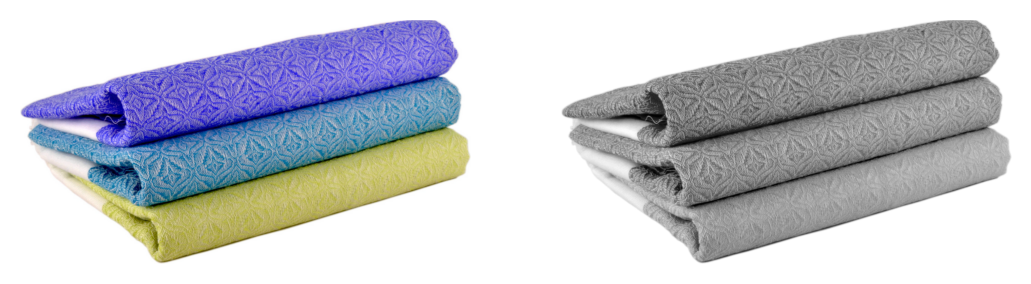

In [7]:
# read image
image = cv2.imread(df_images["image_path"].iloc[1], 1)
# convert to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plot images
plt.figure(dpi=200)
plt.subplot(121)
imshow(image)
plt.subplot(122)
imshow(gray)

In [8]:
# convert back to rgb-scale for upcoming plots
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
gray_rgb.shape

(1293, 2388, 3)

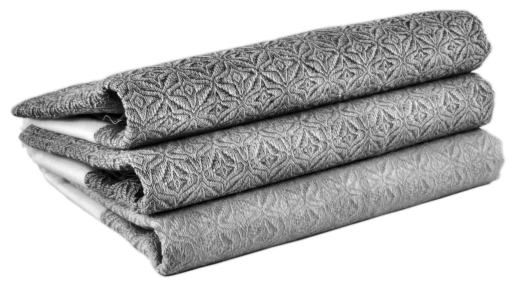

In [9]:
# Let's improve the contrast using Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl_image = clahe.apply(gray)
imshow(cl_image)

In [11]:
# Detect keypoint features with SIFT
sift = cv2.SIFT_create()
kp = sift.detect(cl_image, None)
len(kp)

52368

There is a lot of keypoints. Let's look at the number of keypoints we can detect on the original image :

In [12]:
# Detect keypoint features with SIFT
kp = sift.detect(gray, None)
len(kp)

25445

There is still too much keypoints. Let's blur out the image to reduce the number of keypoints :

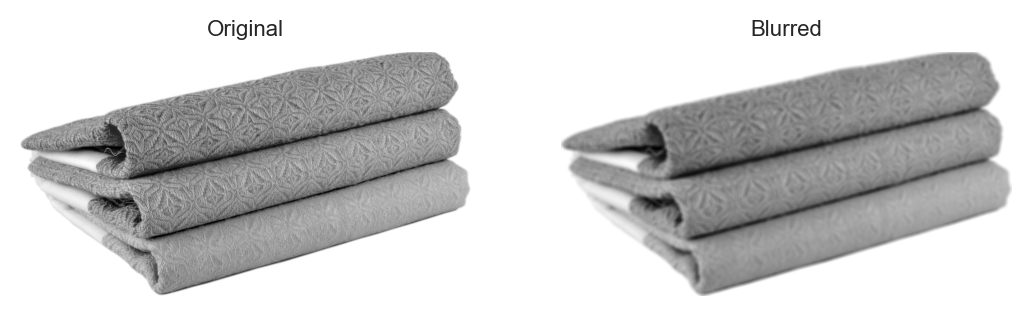

In [20]:
kernel = (20, 20)
blurred = cv2.blur(gray, kernel)
plt.figure(dpi=200)
ax = plt.subplot(121)
ax.set_title("Original", size=8)
imshow(gray)
ax = plt.subplot(122)
ax.set_title("Blurred", size=8)
imshow(blurred)

In [21]:
sift = cv2.SIFT_create()
kp = sift.detect(blurred, None)
len(kp)

155

This is better. Let's look at the keypoints on the image

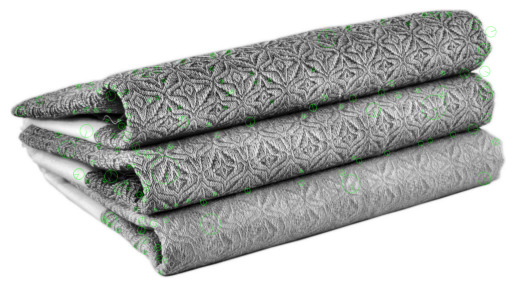

In [22]:
img = cv2.drawKeypoints(
    cl_image,
    kp,
    cl_image,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
imshow(img)

We can't see much with the default `drawKeypoints` method of OpenCV.
<br>
Let's build our own function to better visualize the keypoints :

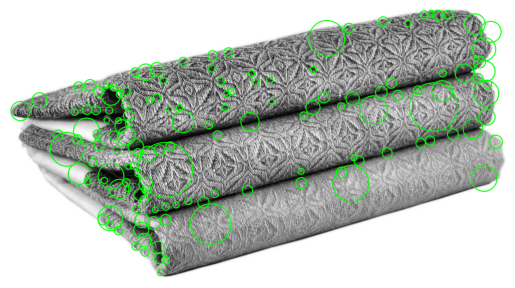

In [23]:
def drawKeypoints(image, keypoints, color=(0, 255, 0), thickness=3):
    img = image.copy()
    for keypoint in keypoints:
        x = np.uint16(keypoint.pt[0])
        y = np.uint16(keypoint.pt[1])
        size = np.uint16(keypoint.size)
        cv2.circle(img, (x, y), size, color, thickness=thickness, lineType=8, shift=0)
    imshow(img)


cl_rgb = cv2.cvtColor(cl_image, cv2.COLOR_GRAY2RGB)
drawKeypoints(cl_rgb, kp, (0, 255, 0), 3)

### Application on several images

We are going to apply the previous operations on several images and visualize the results.

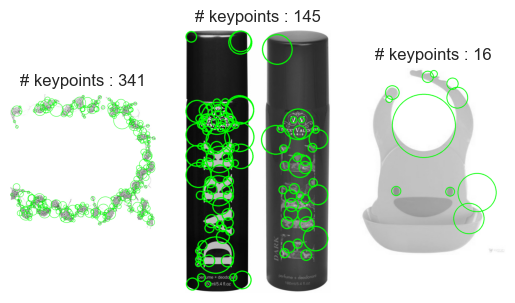

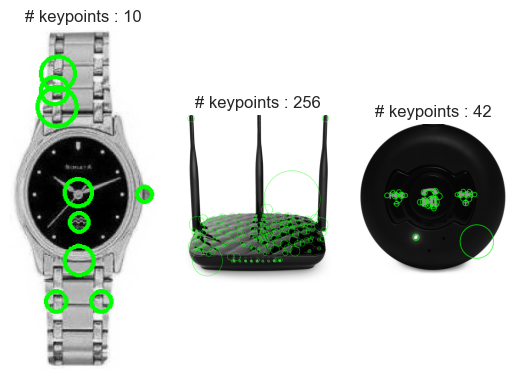

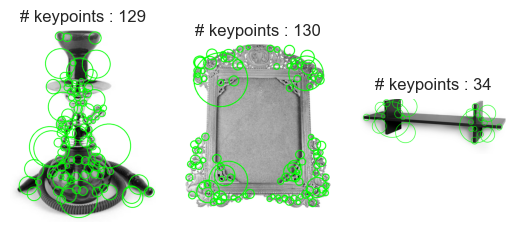

In [24]:
sift = cv2.SIFT_create()
blur_kernel = (20, 20)
i = 0
for path in df_images["image_path"].sample(9, random_state=9):
    if i % 3 == 0:
        plt.figure()
    gray = cv2.imread(path, 0)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    gray_rgb.shape
    blurred = cv2.blur(gray, blur_kernel)
    keypoints = sift.detect(blurred, None)
    plt.subplot(130 + (i % 3) + 1)
    plt.title(f"# keypoints : {len(keypoints)}")
    drawKeypoints(gray_rgb, keypoints, (0, 255, 0), 3)
    i += 1

## Detection of descriptors from all images

### Descriptors creation

* Creation of a list of descriptors per image (``sift_descriptors_by_img``) which will be used to generate images' histograms.
* Creation of a list of descriptors for all images (``sift_descriptors_all``) which will be used to create clusters of descriptors.

In [15]:
# cell to stop the run because the next cell takes a while to compute descriptors
error

In [16]:
%%time
sift_descriptors = []
sift = cv2.SIFT_create(100)  # maximum of 100 keypoints
blur_kernel = (20, 20)
for i in tqdm(range(df_images.shape[0])):
    gray = cv2.imread(df_images["image_path"].iloc[i], 0)  # import image in grayscale
    blurred = cv2.blur(gray, blur_kernel)
    kp, des = sift.detectAndCompute(blurred, None)
    sift_descriptors.append(des)

100%|██████████| 1050/1050 [08:45<00:00,  2.00it/s] 

CPU times: total: 13min 35s
Wall time: 8min 45s


We are going to transform the ``sift_descriptors`` list into a numpy array. Then, we concatenate all the elements in ``sift_descriptors_all``

In [17]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype="object")
sift_descriptors_by_img.shape

(1050,)

In [18]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 343 has 0 dimension(s)

There is an error because the element at index **343** is empty, meaning that the SIFT algorithm did not detect any keypoint. Let's take a closer look at this :

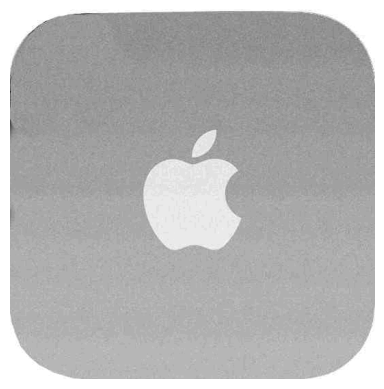

In [19]:
# Let's take a look at the image in question
index = 343
gray = cv2.imread(df_images["image_path"].iloc[index], 0)
imshow(gray)

In [20]:
gray.min(), gray.max()

(220, 255)

Let's increase the contrast by equalizing the image histogram and see if we can detect keypoints on the new image.

100

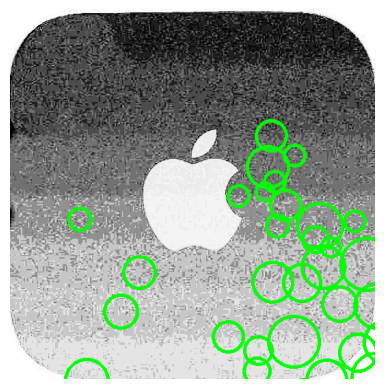

In [21]:
equ = cv2.equalizeHist(np.uint8(gray))
keypoints = sift.detect(equ, None)
equ_rgb = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
drawKeypoints(equ_rgb, kp, (0, 255, 0), 3)
len(kp)

Let's insert the image descriptors in ``sift_descriptors``.

In [22]:
kp, des = sift.compute(equ, keypoints)
sift_descriptors[index] = des
sift_descriptors[index].shape

(100, 128)

In [23]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype="object")
sift_descriptors_by_img.shape

(1050,)

Now we can concatenate the elements of `sift_descriptors_by_img`

In [24]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)
sift_descriptors_all.shape

(80828, 128)

There is a total of **80 828** descriptors across all images. Let's save them using ``pickle`` :

In [25]:
# # Save descriptors
# import pickle
# with open('data/sift_descriptors', 'wb') as fichier:
#     my_pickler = pickle.Pickler(fichier)
#     my_pickler.dump(sift_descriptors_by_img)

In [25]:
# # load descriptors
# import pickle
# with open('data/sift_descriptors', 'rb') as fichier:
#     my_unpickler = pickle.Unpickler(fichier)
#     sift_descriptors_by_img = my_unpickler.load()
# sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

### Creating descriptor clusters

We are going to group the descriptors into clusters using a clustering algorithm.
We will use ``MiniBatchKMeans`` to reduce processing times.

In [26]:
start = time.time()

k = round(np.sqrt(len(sift_descriptors_all)))
print("Estimated number of clusters :", k)

# Clustering
print(f"Creating {k} clusters of descriptors ...")
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_descriptors_all)

end = time.time()
print("MiniBatchKMeans processing time : %.2f seconds" % (end - start))

Estimated number of clusters : 284
Creating 284 clusters of descriptors ...


c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans processing time : 2.53 seconds


### Creating Image Features

For each image, we will determine the cluster of each descriptor and then build a histogram representing the number of descriptors per cluster.
<br>
We will consider the features of an image as the histogram corresponding to that image, i.e., the number of descriptors per cluster.

In [27]:
def build_histogram(kmeans, des, image_num):
    labels = kmeans.predict(des)
    hist = np.zeros(k)
    nb_des = len(des)  # or des.shape[0]
    if nb_des == 0:
        print("warning : no descriptor for image", image_num)
    for i in labels:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a histogram matrix
hist_vectors = []

# Creating histograms (features)
start = time.time()
for i, image_desc in enumerate(sift_descriptors_by_img):
    # if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i)  # computes the histogram
    hist_vectors.append(hist)  # the histogram is the feature vector
im_features = np.asarray(hist_vectors)

end = time.time()
print("Time to create histograms : %.2f seconds" % (end - start))
print("Dimensions of the histogram matrix :", im_features.shape)

Time to create histograms : 0.27 seconds
Dimensions of the histogram matrix : (1050, 284)


### Dimensionality reduction

#### PCA

* PCA reduction helps create uncorrelated features and reduces their dimensionality while maintaining a high level of explained variance.
* The impact is a better separation of data and a reduced processing time for t-SNE.

In [28]:
print("Dataset dimensions before PCA :", im_features.shape)
pca = PCA(n_components=0.95)
feat_pca = pca.fit_transform(im_features)
print("Dataset dimensions after PCA :", feat_pca.shape)

Dataset dimensions before PCA : (1050, 284)
Dataset dimensions after PCA : (1050, 191)


#### t-SNE

In [29]:
tsne = manifold.TSNE(
    n_components=2, perplexity=30, n_iter=1000, init="random", random_state=6
)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["X_tsne1", "X_tsne2"])
df_tsne["class"] = df_images["category"]
df_tsne.head()

,X_tsne1,X_tsne2,class
0,5.727871,21.784243,Home Furnishing
1,20.195164,18.474737,Baby Care
2,23.958656,1.691640,Baby Care
3,-7.960743,19.015556,Home Furnishing
4,5.948412,-1.604988,Home Furnishing


### Vizualisation : display t-SNE data labeled by categories

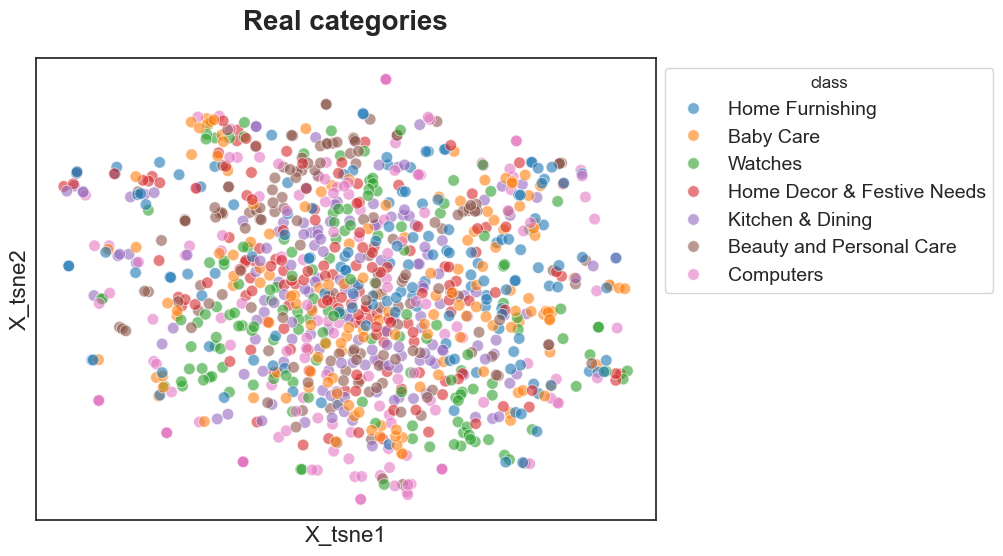

In [30]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="X_tsne1",
    y="X_tsne2",
    hue="class",
    data=df_tsne,
    legend="auto",
    palette=sns.color_palette("tab10", n_colors=n_labels),
    s=70,
    alpha=0.6,
)

ax.set_title(
    "Real categories",
    fontsize=20,
    pad=35,
    fontweight="bold",
    verticalalignment="top",
)
ax.set_xlabel("X_tsne1", fontsize=16, fontweight="normal")
ax.set_ylabel("X_tsne2", fontsize=16, fontweight="normal")
# ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={"size": 14})
ax.set_xticks([])
ax.set_yticks([])
# plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

All categories are mixed together, making it difficult to discern anything significant...

### Similarity measurement between real categories and clusters

In [31]:
ARI, X_tsne, labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.02 duration :  7.1 s


As expected, the ARI is very poor. This is because the categories are not separated.

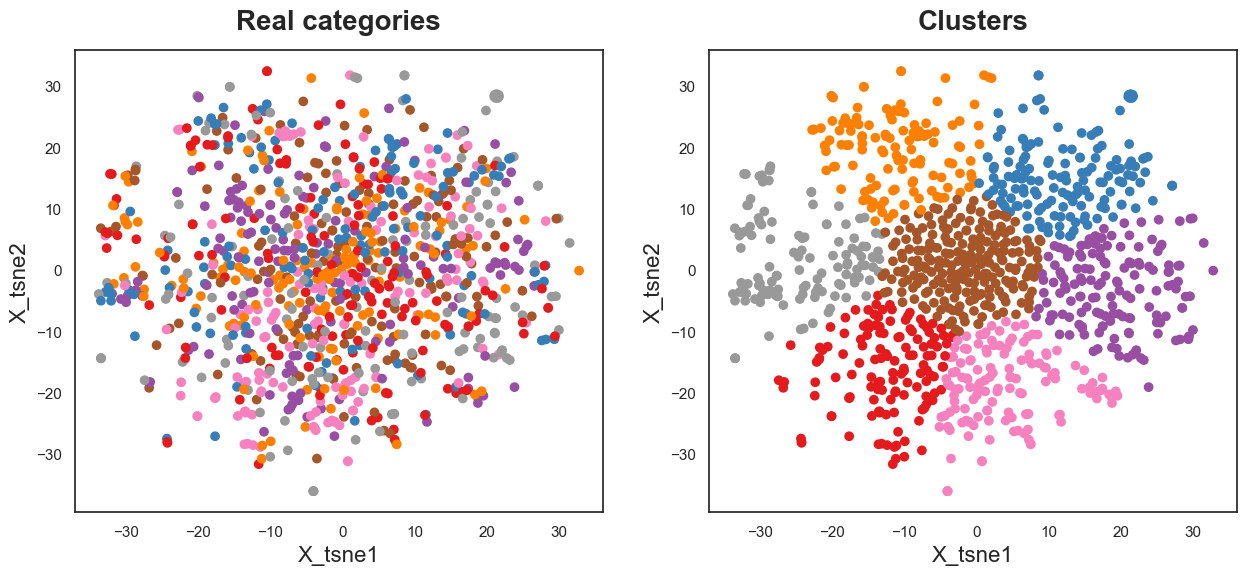

ARI :  0.02


In [32]:
TSNE_visu_fct(
    X_tsne,
    cat_labels,
    labels,
    categories,
    ARI,
    legend_loc="upper left",
    show_ticks=True,
    legend=False,
)

# Transfer Learning with Keras

We are going to use the VGG-16 model provided by Keras and pre-trained on ImageNet, removing the last layer which is used for classification.

In [36]:
# load VGG-16 model pretrained on ImageNet
model = VGG16()

# remove the last layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Loading images

In [37]:
df_images = pd.read_csv("data/df_images.csv", index_col=0)
display(df_images.head())

,image_path,category,label
0,./data/images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,0
1,./data/images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,1
2,./data/images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,1
3,./data/images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,0
4,./data/images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,0


We first need to load the images and preprocess them to fit the specifications of the input images for VGG-16.
To do this, we will use functions from the `keras.utils` and `keras.preprocessing.vgg16` modules:
1. VGG-16 receives images of size (224, 224, 3): the `load_img` function loads the image and resizes it correctly.
2. Keras processes images as numpy arrays: `img_to_array` converts the loaded image into a numpy array.
3. The network must receive as input a collection of images, stored in a 4-dimensional array, where the dimensions correspond (in order) to (number of images, width, height, depth).
4. Finally, `preprocess_input` applies the same preprocessing steps used during the pretraining of VGG-16.

Thus, we prepare the image as follows:

In [38]:
images = []
for path in df_images["image_path"]:
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    images.append(img)
images = np.array(images)
images = preprocess_input(images)
images.shape

c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

In [39]:
# Feature extraction
features = model.predict(images)
features.shape

33/33 [==============================] - 152s 5s/step


(1050, 4096)

## Dimensionality reduction

### PCA

In [40]:
print("Dataset dimensions before PCA :", features.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(features)
print("Dataset dimensions after PCA :", feat_pca.shape)

Dataset dimensions before PCA : (1050, 4096)
Dataset dimensions after PCA : (1050, 803)


### t-SNE

In [41]:
ARI, X_tsne, cls_labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.49 duration :  15.3 s


In [42]:
# switch clusters for visualization
switch(cls_labels, 1, 6)
switch(cls_labels, 2, 4)

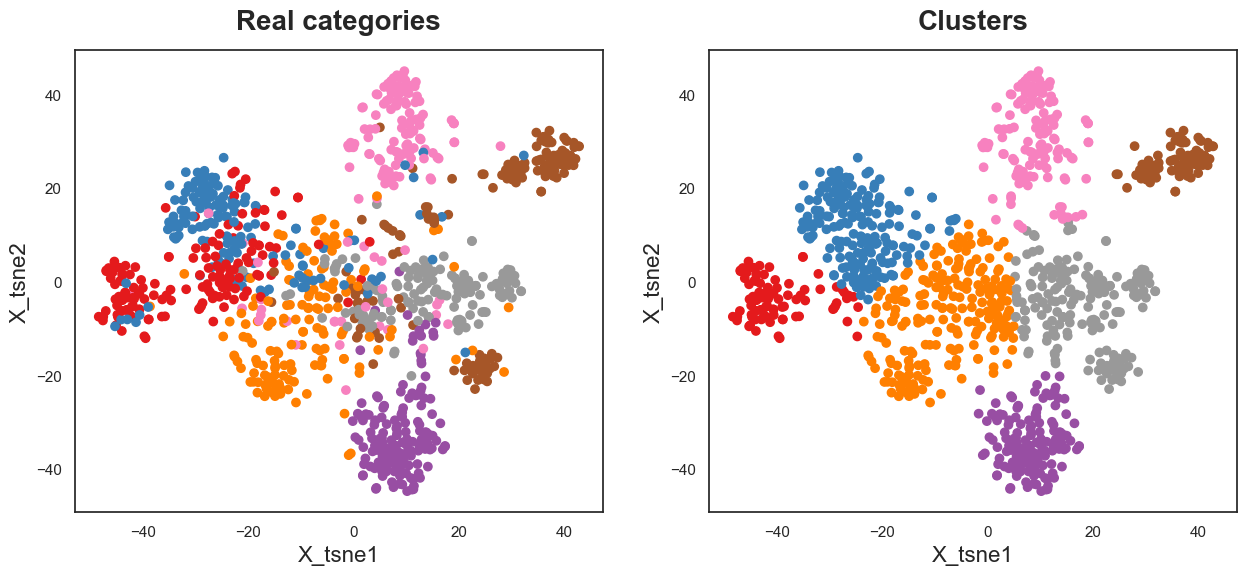

ARI :  0.49


In [43]:
TSNE_visu_fct(
    X_tsne,
    cat_labels,
    cls_labels,
    categories,
    ARI,
    legend_loc="upper left",
    show_ticks=True,
    legend=False,
)

## Confusion matrix

In [44]:
conf_mat = confusion_matrix(cat_labels, cls_labels)
print(conf_mat)

[[ 78  64   0   8   0   0   0]
 [  7 112   0  22   1   5   3]
 [  0   0 134   2   0   0  14]
 [  3   8   3 126   0   1   9]
 [  0   0   0  20  78  15  37]
 [  1   3   1  16   1 118  10]
 [  0   1   1  29   0   1 118]]


In [45]:
print(classification_report(cat_labels, cls_labels))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65       150
           1       0.60      0.75      0.66       150
           2       0.96      0.89      0.93       150
           3       0.57      0.84      0.68       150
           4       0.97      0.52      0.68       150
           5       0.84      0.79      0.81       150
           6       0.62      0.79      0.69       150

    accuracy                           0.73      1050
   macro avg       0.78      0.73      0.73      1050
weighted avg       0.78      0.73      0.73      1050



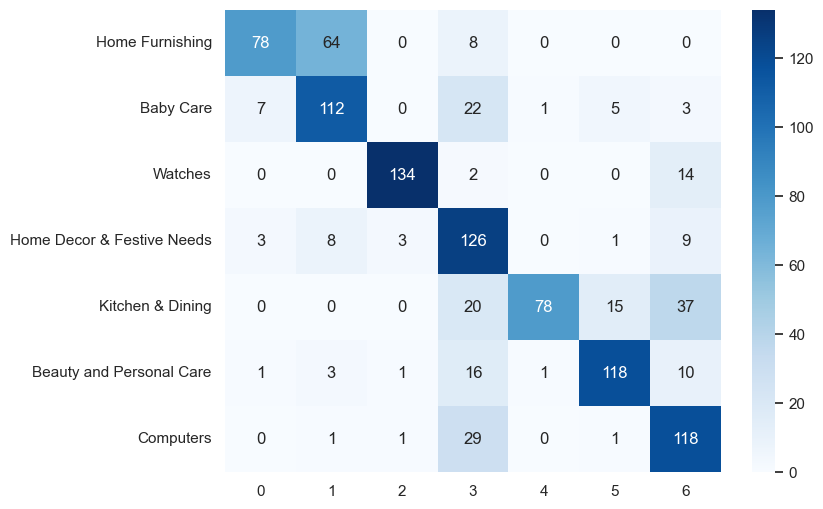

In [46]:
# Confusion matrix visualization
df_cm = pd.DataFrame(conf_mat, index=categories, columns=[i for i in range(n_labels)])
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.show()

## Classification with a Logistic Regression

Let's train a logistic regression on the PCA features.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    feat_pca, cat_labels, test_size=0.2, random_state=2024
)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

Results of the Logistic Regression :
Accuracy on training set : 1.000
Accuracy on validation set : 0.843


The model seems to overfit.